In [1]:
!pip install eli5
!pip install pdpbox
!pip install shap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from xgboost import XGBClassifier, plot_importance
import warnings
import eli5
import shap
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
data = pd.read_csv('../input/heart-disease-cleveland-uci/heart_cleveland_upload.csv')
# To display the top 5 rows
data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [4]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


In [5]:
data.shape

(297, 14)

In [6]:
heart = data.copy()

In [7]:
target = 'condition'
features_list = list(heart.columns)
features_list.remove(target)

In [8]:
y = heart.pop('condition')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(heart, y, test_size=0.2, random_state=33)
X_train.shape, X_test.shape

((237, 13), (60, 13))

In [ ]:
%%time

xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)

[15:17:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 167 ms, sys: 1.96 ms, total: 169 ms
Wall time: 49.1 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
# make predictions for test data
xgb_predictions = xgb.predict(X_test)

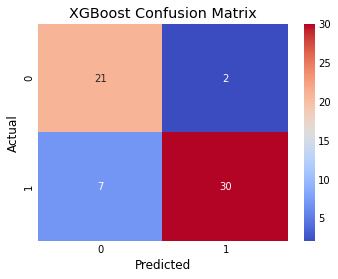

              precision    recall  f1-score   support

           0       0.75      0.91      0.82        23
           1       0.94      0.81      0.87        37

    accuracy                           0.85        60
   macro avg       0.84      0.86      0.85        60
weighted avg       0.87      0.85      0.85        60



In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, xgb_predictions), annot=True, fmt="d", cmap="coolwarm")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_predictions))

## Permutation Importance

In [13]:
import eli5
from eli5.sklearn import PermutationImportance

In [14]:
eli5.show_weights(xgb.get_booster(), top=15)

Weight,Feature
0.2559,thal
0.1621,cp
0.1615,ca
0.0592,exang
0.0560,oldpeak
0.0507,slope
0.0466,fbs
0.0460,sex
0.0398,age
0.0348,chol


In [15]:
tgt = 6
print('Reference:', y_test.iloc[tgt])
print('Predicted:', xgb_predictions[tgt])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[tgt], 
                     feature_names=list(heart.columns), show_feature_values=True)

Reference: 1
Predicted: 1


In [ ]:
%%time

xgb_array = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb_array.fit(X_train.values, y_train)

[15:17:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 181 ms, sys: 12.3 ms, total: 194 ms
Wall time: 50.5 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## SHAP

In [ ]:
import shap

shap.initjs()

In [ ]:

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [19]:
X_shap = pd.DataFrame(shap_values)
X_shap.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.669860,0.482459,0.620434,-1.126800,-0.374257,0.062994,-0.680173,-0.937682,-0.053942,-2.054053,-0.233142,0.804340,0.359287
1,-1.294715,-0.493515,-0.662293,-0.133700,-0.450159,0.029637,-0.192750,-0.637688,-0.210133,-0.352575,0.916539,-1.310680,-1.164720
2,0.028315,-0.710275,1.088892,0.558033,0.346271,-0.139676,0.310020,0.610800,0.753798,1.154980,0.420168,2.170985,1.290934
3,-0.049543,0.313959,0.943176,0.082306,0.380460,0.065999,-0.398400,0.580469,0.752070,1.561530,0.518611,1.678789,1.228367
4,0.018207,-0.749259,1.222633,0.544088,0.082887,0.032069,0.396871,-0.113106,-0.263104,1.119788,0.311731,2.392574,0.986050


In [20]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  -0.4635163


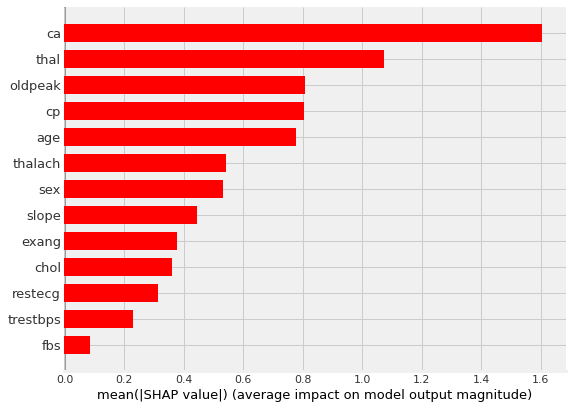

In [21]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red')


In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[6,:], X_test.iloc[6,:])

In [24]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[15,:], X_test.iloc[15,:])

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

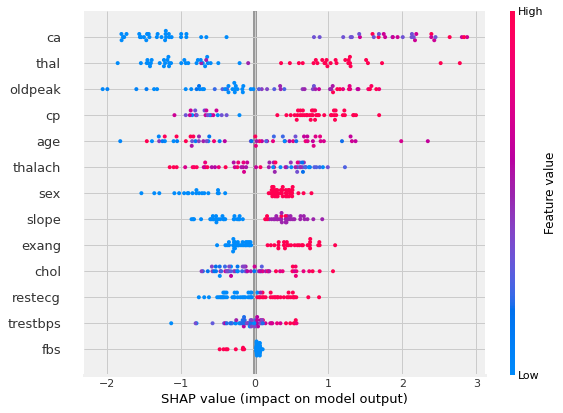

In [26]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

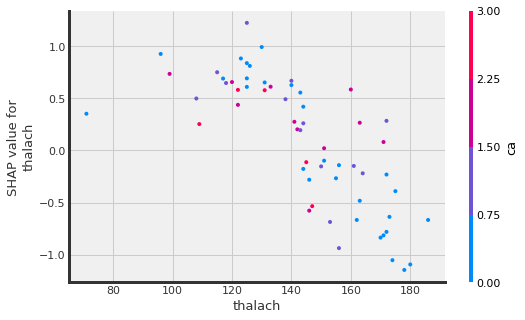

In [27]:
shap.initjs()
shap.dependence_plot(ind='thalach', interaction_index='ca',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

In [28]:
import joblib

joblib.dump(xgb, "xgboost_cardiovascular_model.pkl")

['xgboost_cardiovascular_model.pkl']